In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchsummary import summary


import matplotlib.pyplot as plt
import numpy as np
import os
import random

import albumentations as A
from albumentations.pytorch import ToTensorV2

from sklearn.metrics import confusion_matrix
import seaborn as sns
import json

In [ ]:
do_train = False

### Seed per riproducibilità

In [ ]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
torch.manual_seed(seed)


In [ ]:
torch.cuda.is_available()

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

## Connessione a Google Drive

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

In [ ]:
 %cd /gdrive/My\ Drive/PYTORCH/slides/Sezione\ 5/Pratica

## Food Classification Dataset

IL dataset originale contiene 24K immagini di 35 varietà di cibo indiano e occidentale.

Ho semplificato il dataset tenedo solo 14 classi con rispettivamente 640 immagini di train, 160 di validation e 200 di test.

Le immagini sono RGB e hanno dimensione 512 x 512


In [ ]:
class Transforms:
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img, *args, **kwargs):
        return self.transforms(image=np.array(img))['image']

In [ ]:
transform = A.Compose([
            A.Resize(256, 256),
            A.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
            ToTensorV2(),
        ])

In [ ]:
#carica i dataset

trainset = torchvision.datasets.ImageFolder(root='dataset/train', transform=Transforms(transform))

valset = torchvision.datasets.ImageFolder(root='dataset/val', transform=Transforms(transform))

testset = torchvision.datasets.ImageFolder(root='dataset/test',transform=Transforms(transform))

In [ ]:
trainset[0][0].shape

In [ ]:
len(trainset), len(valset), len(testset)

In [ ]:
# funzione per convertire un'immagine da tensore ad un formato visualizzabile

def back_to_image(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    return np.transpose(npimg, (1, 2, 0))


In [ ]:
image = back_to_image(trainset[0][0])
plt.imshow(image)
plt.show()

In [ ]:
classes = trainset.classes
classes

In [ ]:
len(classes)

In [ ]:
iteration = 1

In [ ]:
num_row = 2
num_col = 5
fig, axes = plt.subplots(num_row, num_col, figsize=(10*num_row,2*num_col))
for i in range(num_row*num_col):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(back_to_image(trainset[iteration * num_row * num_col + i][0]))
    ax.set_title('{}'.format(classes[int(trainset[iteration * num_row * num_col + i][1])]))
plt.tight_layout()
plt.show()
iteration += 1

In [ ]:

batch_size = 128

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                          shuffle=False)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False)

Funzioni per train e test

In [ ]:
class EarlyStopping:
    def __init__(self, save_path, patience=5, min_delta=0):

        self.save_path = save_path
        self.patience = patience
        self.min_delta = min_delta
        self.min_val_loss = None
        self.counter = 0
        self.early_stop = False

    def __call__(self, validation_loss, model):

        if self.min_val_loss is None:     #Prima epoca
          self.min_val_loss = validation_loss
          self.save_checkpoint(model)

        elif (self.min_val_loss - validation_loss) > self.min_delta: #Epoca con miglioramento
          self.min_val_loss = validation_loss
          self.save_checkpoint(model)
          self.counter = 0


        else:     #Nessun miglioramento
          self.counter +=1
          if self.counter >= self.patience:
            self.early_stop = True

    def save_checkpoint(self, model):
      torch.save(model.state_dict(), self.save_path)

In [ ]:
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    processed_data = 0

    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device) #[128, 256, 256], [128, 14]

        optimizer.zero_grad()

        outputs = model(inputs) #[128, 14]
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        processed_data += len(inputs)

    return running_loss / processed_data

In [ ]:
def test_epoch(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for i, data in enumerate(test_loader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    return running_loss / total, correct / total

In [ ]:
def train(model, train_loader, test_loader, criterion, optimizer, device, epochs=100, early_stopping=None):
    train_losses = []
    test_losses = []
    test_accuracies = []

    for epoch in range(epochs):
        train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
        test_loss, test_accuracy = test_epoch(model, test_loader, criterion, device)

        train_losses.append(train_loss)
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)

        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {test_loss:.4f}, Validation Accuracy: {test_accuracy:.4f}')

        if early_stopping is not None:
            early_stopping(test_loss, model)
            if early_stopping.early_stop:
                print("Early stopping")
                break

    return train_losses, test_losses, test_accuracies

In [ ]:

def plot_confusion_matrix(model, test_loader, device):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for i, data in enumerate(test_loader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)

            outputs = model(inputs)

            _, predicted = torch.max(outputs, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10,7))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes, cmap='Blues')

## Baseline

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)     #Params 5*5*3 = 75 + 1 = 76 * 6 = 456
        self.pool = nn.MaxPool2d(2)         #Params 0
        self.conv2 = nn.Conv2d(6, 16, 5)    #Params 5*5*6 = 150 + 1 = 151 * 16 = 2416


        self.fc1 = nn.Linear(59536, 120)      #Params 59536 + 1 = 59537 * 120 = 7 144 440
        self.fc2 = nn.Linear(120, 84)       #Params 120 + 1 = 121 * 84 = 10 164
        self.fc3 = nn.Linear(84, 14)        #Params 84 + 1 = 85 * 14 = 1190

    def forward(self, x): #Input [N,3,256,256]
        x = self.conv1(x) #Output [N,6,252,252]
        x = F.relu(x)
        x = self.pool(x)  #Output [N,6,126,126]

        x = self.conv2(x) #Output [N,16,122,122]
        x = F.relu(x)
        x = self.pool(x)  #Output [N,16,61,61]

        x = torch.flatten(x, 1) # flatten su tutte le dimensioni [N, 16*61*61] = [N, 59 536]

        x = self.fc1(x)  #Output [N,120]
        x = F.relu(x)
        x = self.fc2(x)  #Output [N,84]
        x = F.relu(x)
        x = self.fc3(x)  #Output [N,14]

        return x

In [ ]:
baseline = Net().to(device)

In [ ]:
summary(baseline, (3,256,256))

In [ ]:
baseline_save_folder = "models/baseline/"
os.makedirs(baseline_save_folder, exist_ok = True)
baseline_save_file = os.path.join(baseline_save_folder,"model.pt")
baseline_save_log = os.path.join(baseline_save_folder,"log.json")


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(baseline.parameters(), lr=0.001)
early_stopping = EarlyStopping(baseline_save_file, patience=5, min_delta=0)
epochs = 100

In [ ]:
if do_train:
    train_losses, test_losses, test_accuracies = train(baseline, trainloader, valloader, criterion, optimizer, device, epochs, early_stopping)
    to_save_json = {"train_losses":train_losses,
                "test_losses":test_losses,
                "test_accuracies":test_accuracies}
    with open(baseline_save_log, 'w') as f:
      json.dump(to_save_json, f)

In [ ]:
baseline.load_state_dict(torch.load(baseline_save_file))
with open(baseline_save_log, "r") as f:
    baseline_log = json.load(f)

In [ ]:
if do_train:
  val_loss, val_accuracy = test_epoch(baseline, valloader, criterion, device)
else:
  val_loss = baseline_log['test_losses'][-1]
  val_accuracy = baseline_log['test_accuracies'][-1]
print("Accuracy on val set: ", val_accuracy)

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(baseline_log['train_losses'], label='Train Loss')
plt.plot(baseline_log['test_losses'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

In [ ]:
# print confusion matrix
if do_train:
  plot_confusion_matrix(baseline, valloader, device)

## Augmentation

La quantità limitata di dati crea evidenti problemi di overfitting.

Andiamo ad applicare alcune augmentation per migliorare le performace

In [ ]:
augment = A.Compose([
            A.Resize(256, 256),
            A.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),

            A.RandomRotate90(),
            A.Flip(),
            A.Transpose(),

            ToTensorV2(),
        ])

In [ ]:
#carica i dataset

trainset_aug = torchvision.datasets.ImageFolder(root='dataset/train', transform=Transforms(augment))

In [ ]:
iteration = 200

In [ ]:
num_row = 2
num_col = 5
fig, axes = plt.subplots(num_row, num_col, figsize=(10*num_row,2*num_col))
for i in range(num_row*num_col):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(back_to_image(trainset_aug[iteration * num_row * num_col + i][0]))
    ax.set_title('{}'.format(classes[int(trainset_aug[iteration * num_row * num_col + i][1])]))
plt.tight_layout()
plt.show()
iteration += 1

In [ ]:

batch_size = 128

trainloader_aug = torch.utils.data.DataLoader(trainset_aug, batch_size=batch_size,
                                          shuffle=True)

In [ ]:
aug_baseline = Net().to(device)

In [ ]:
aug_baseline_save_folder = "models/aug_baseline/"
os.makedirs(aug_baseline_save_folder, exist_ok = True)
aug_baseline_save_file = os.path.join(aug_baseline_save_folder,"model.pt")
aug_baseline_save_log = os.path.join(aug_baseline_save_folder,"log.json")

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(aug_baseline.parameters(), lr=0.001)
early_stopping = EarlyStopping(aug_baseline_save_file, patience=5, min_delta=0)
epochs = 100

In [ ]:
if do_train:
    train_losses, test_losses, test_accuracies = train(aug_baseline, trainloader_aug, valloader, criterion, optimizer, device, epochs, early_stopping)
    to_save_json = {"train_losses":train_losses,
                "test_losses":test_losses,
                "test_accuracies":test_accuracies}
    with open(aug_baseline_save_log, 'w') as f:
      json.dump(to_save_json, f)

In [ ]:
aug_baseline.load_state_dict(torch.load(aug_baseline_save_file))
with open(aug_baseline_save_log, "r") as f:
    aug_baseline_log = json.load(f)

In [ ]:

if do_train:
  val_loss, val_accuracy = test_epoch(baseline, valloader, criterion, device)
else:
  val_loss = aug_baseline_log['test_losses'][-1]
  val_accuracy = aug_baseline_log['test_accuracies'][-1]

print("Accuracy on val set: ", val_accuracy)

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(aug_baseline_log['train_losses'], label='Train Loss')
plt.plot(aug_baseline_log['test_losses'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

In [ ]:
if do_train:
    plot_confusion_matrix(aug_baseline, valloader, device)

## Transfer Learning

Andiamo a prendere la backbone di un modello pretrainato.

In questo caso, andiamo a prendere VGG16

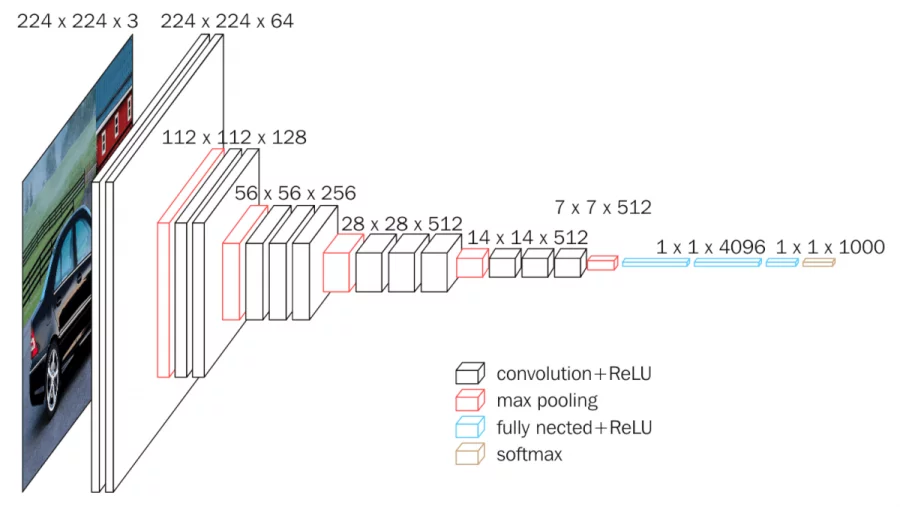

In [122]:
from torchvision.models import vgg16, VGG16_Weights

In [123]:
vgg = vgg16(weights = VGG16_Weights.IMAGENET1K_V1).to(device)

In [124]:
summary(vgg, (3,256,256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
              ReLU-2         [-1, 64, 256, 256]               0
            Conv2d-3         [-1, 64, 256, 256]          36,928
              ReLU-4         [-1, 64, 256, 256]               0
         MaxPool2d-5         [-1, 64, 128, 128]               0
            Conv2d-6        [-1, 128, 128, 128]          73,856
              ReLU-7        [-1, 128, 128, 128]               0
            Conv2d-8        [-1, 128, 128, 128]         147,584
              ReLU-9        [-1, 128, 128, 128]               0
        MaxPool2d-10          [-1, 128, 64, 64]               0
           Conv2d-11          [-1, 256, 64, 64]         295,168
             ReLU-12          [-1, 256, 64, 64]               0
           Conv2d-13          [-1, 256, 64, 64]         590,080
             ReLU-14          [-1, 256,

In [125]:
#Freeze
for param in vgg.parameters():
    param.requires_grad = False

Dobbiamo sostituire la parte fully connected con il nostro classificatore, usando un avgpool e un fully connected

In [126]:
class VGGClassifier(nn.Module):
    def __init__(self, vgg_backbone, in_features, num_classes):
        super().__init__()
        self.features = vgg_backbone.features
        self.pooling = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(in_features, num_classes)
    def forward(self, x):
        x = self.features(x) #[N, 512, 8, 8]
        x = self.pooling(x) #[N, 512, 1, 1]
        x = torch.flatten(x, 1) #[N, 512]
        x = self.fc(x) #[N, 14]
        return x

In [127]:
vgg = VGGClassifier(vgg, 512, 14).to(device)


In [128]:
summary(vgg, (3,256,256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
              ReLU-2         [-1, 64, 256, 256]               0
            Conv2d-3         [-1, 64, 256, 256]          36,928
              ReLU-4         [-1, 64, 256, 256]               0
         MaxPool2d-5         [-1, 64, 128, 128]               0
            Conv2d-6        [-1, 128, 128, 128]          73,856
              ReLU-7        [-1, 128, 128, 128]               0
            Conv2d-8        [-1, 128, 128, 128]         147,584
              ReLU-9        [-1, 128, 128, 128]               0
        MaxPool2d-10          [-1, 128, 64, 64]               0
           Conv2d-11          [-1, 256, 64, 64]         295,168
             ReLU-12          [-1, 256, 64, 64]               0
           Conv2d-13          [-1, 256, 64, 64]         590,080
             ReLU-14          [-1, 256,

In [129]:
vgg_save_folder = "models/vgg/"
os.makedirs(vgg_save_folder, exist_ok = True)
vgg_save_file = os.path.join(vgg_save_folder,"model.pt")
vgg_save_log = os.path.join(vgg_save_folder,"log.json")

In [130]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(vgg.parameters(), lr=0.001)
early_stopping = EarlyStopping(vgg_save_file, patience=5, min_delta=0)
epochs = 100

In [131]:
if do_train:
    train_losses, test_losses, test_accuracies = train(vgg, trainloader_aug, valloader, criterion, optimizer, device, epochs, early_stopping)
    to_save_json = {"train_losses":train_losses,
                "test_losses":test_losses,
                "test_accuracies":test_accuracies}
    with open(vgg_save_log, 'w') as f:
      json.dump(to_save_json, f)

In [132]:
vgg.load_state_dict(torch.load(vgg_save_file))
with open(vgg_save_log, "r") as f:
    vgg_log = json.load(f)

In [133]:

if do_train:
  val_loss, val_accuracy = test_epoch(baseline, valloader, criterion, device)
else:
  val_loss = vgg_log['test_losses'][-1]
  val_accuracy = vgg_log['test_accuracies'][-1]
print("Accuracy on val set: ", val_accuracy)

Accuracy on val set:  0.8071428571428572


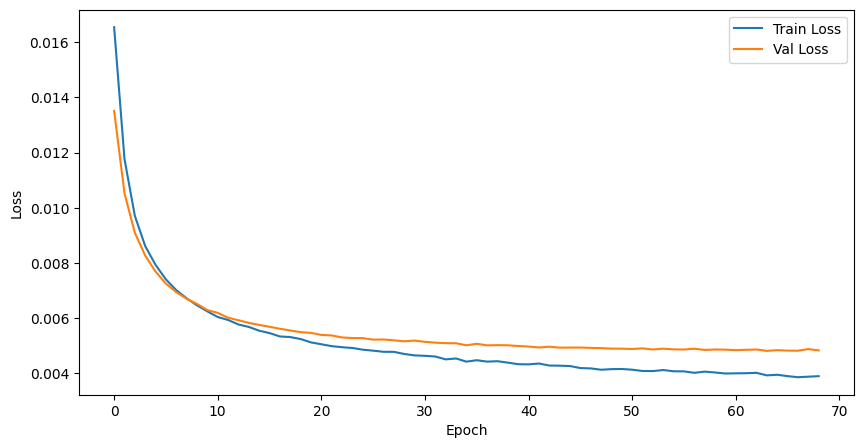

In [134]:
plt.figure(figsize=(10,5))
plt.plot(vgg_log['train_losses'], label='Train Loss')
plt.plot(vgg_log['test_losses'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

In [135]:
# print confusion matrix
plot_confusion_matrix(vgg, valloader, device)

KeyboardInterrupt: 

## Test Finale

In [136]:
if do_train:
  _ , accuracy_baseline = test_epoch(baseline, valloader, criterion, device)
else:
  accuracy_baseline = baseline_log['test_accuracies'][-1]

In [137]:
accuracy_baseline

0.29776785714285714

In [138]:
if do_train:
  _ , accuracy_aug = test_epoch(aug_baseline, valloader, criterion, device)
else:
  accuracy_aug = aug_baseline_log['test_accuracies'][-1]

In [139]:
accuracy_aug

0.3821428571428571

In [140]:
if do_train:
  _,  accuracy_vgg = test_epoch(vgg, valloader, criterion, device)
else:
  accuracy_vgg = vgg_log['test_accuracies'][-1]

In [141]:
accuracy_vgg

0.8071428571428572

In [ ]:
# Test della migliore
_ , accuracy_test = test_epoch(vgg, testloader, criterion, device)


0.8132142857142857